In [1]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter

## Pair sound files and annotation

In [2]:
soundfiles = glob.glob('testfiles/**/*.sph', recursive = True)
#annofiles = glob.glob('./**/*.txt', recursive = True) + glob.glob('./**/*.sgml', recursive = True)
data = {}
for soundfile in soundfiles:
    name = soundfile.split('/')[-1].split('.')[0]
    annofile = list(glob.glob('testfiles/**/'+name+'.txt', recursive = True)) + list(glob.glob('testfiles/**/'+name+'.sgml', recursive = True))
    annofile = annofile[0]
    data[soundfile] = annofile
start_load = time.time()
idx = np.random.randint(len(soundfiles))
sph = SPHFile(soundfiles[idx])
junk, sr = sph.content, sph.format['sample_rate']
print(time.time()-start_load)
soundfiles

0.1122596263885498


['testfiles/audiofiles/e960510a.sph',
 'testfiles/audiofiles/h960514_.sph',
 'testfiles/audiofiles/e960513b.sph',
 'testfiles/audiofiles/e960514b.sph',
 'testfiles/audiofiles/e960515_.sph',
 'testfiles/audiofiles/e960513a.sph',
 'testfiles/audiofiles/g960515_.sph',
 'testfiles/audiofiles/e960514a.sph',
 'testfiles/audiofiles/j960510_.sph',
 'testfiles/audiofiles/e960510b.sph']

-80.0

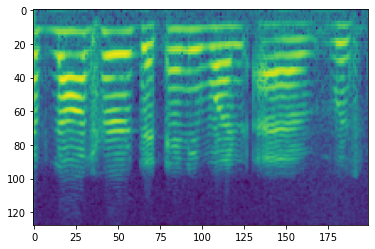

In [3]:
S = librosa.feature.melspectrogram(junk[1000*sr:1002*sr]/(2**15), n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
S_dB = librosa.power_to_db(S, ref=np.max)
plt.imshow(S_dB)
S_dB.min()

## Figure out gender of each speaker

In [4]:
# gender = {}
# for annofile in data.values():
#     doc = parse(annofile)
#     for tag in doc.getroot().iter():
#         if tag.tag in ['segment', 'turn']:
#             if 'spkrtype' in tag.attrib:
#                 gender[tag.attrib['speaker']] = tag.attrib['spkrtype']
gender = np.load('gender.npy', allow_pickle = True).reshape(1)[0]

## Pydub Silence Example

In [5]:
seg = audiosegment.from_numpy_array(junk, sr)
silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
print(sum([b-a for [a, b] in silences]))
print(len(junk))

4928639
28800000


## Annotation Example

In [6]:
annofile = data[soundfiles[np.random.randint(len(soundfiles))]]
doc = parse(annofile)
last_end = 0
for tag in doc.getroot().iter():
    if tag.tag == 'segment': # segment for txt files, turn for sgml files
        pass
        #print(tag.attrib, tag.text, tag.tag, '\n')
        if float(tag.attrib['s_time'])<last_end:
            print('interrupt', last_end, tag.attrib['s_time'])
        last_end = float(tag.attrib['e_time'])
    elif tag.tag == 'turn':
        pass
        #print(tag.attrib, tag.text, tag.tag, '\n')
        if float(tag.attrib['starttime'])<last_end:
            print('interrupt', last_end, tag.attrib['starttime'])
        last_end = float(tag.attrib['endtime'])
tags = [item for item in doc.getroot().iter() if item.tag in ['segment', 'turn']]
segment_idx = np.random.randint(0, len(tags))
example_tag = tags[segment_idx]
if example_tag.tag == 'segment':
    start, end = example_tag.attrib['s_time'], example_tag.attrib['e_time']
else:
    start, end = example_tag.attrib['starttime'], example_tag.attrib['endtime']
print(start, end, example_tag.text_content(), example_tag.attrib['speaker'])
end = int(float(end)*sr)
start = max(end-2*sr, int(float(start)*sr))

interrupt 594.655 594.494
interrupt 2509.923 2509.445
interrupt 2687.813 2687.440
interrupt 3046.352 3046.338
interrupt 3340.777 3340.765
418.026 435.936 
raphael @lameta

forty years old was a passenger on board flight five ninety-two

@lameta was returning from his mother's funeral in venezuela {breath}


adding to the pain these families must endure

news from the medical examiner's office

that most victims will never be identified because of the magnitude of the
crash
 Robert_Vito


# Ending Segments

In [7]:
end_df = pd.DataFrame()
for i, soundfile in enumerate(soundfiles):
    name = soundfile.split('/')[-1].split('.')[0] # name of soundfile
    print(i)
    sph = SPHFile(soundfile)
    sound, sr = sph.content, sph.format['sample_rate']
    annofile = data[soundfile]
    doc = parse(annofile)
    tags = [item for item in doc.getroot().iter() if item.tag in ['segment', 'turn']]
    for j, segment in enumerate(tags):
        speaker = segment.attrib['speaker']
        if segment.tag == 'segment':
            start, end = segment.attrib['s_time'], segment.attrib['e_time']
            if j + 1 < len(tags) and float(tags[j+1].attrib['s_time']) < float(end): # if someone interrupted talking
                #print('interrupt')
                continue
        else:
            start, end = segment.attrib['starttime'], segment.attrib['endtime']
            if j + 1 < len(tags) and float(tags[j+1].attrib['starttime']) < float(end): # if someone interrupted talking
                #print('interrupt')
                continue
        if float(end) > len(sound)/sr: # if end exceeds length, skip
            continue
        end = int(float(end)*sr) # turn to sample index
        start = int(float(start)*sr) # turn to sample index
        if start >= end - 2*sr: # if segment too short
            continue
        start = end-2*sr
        
        
        sound_segment = sound[start:end]
        seg = audiosegment.from_numpy_array(sound_segment, sr)
        silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
        silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
        if silences!= []:
            if silences[-1][1] == 2*sr: # if silence at end, remove that silence
                end = end - 2*sr + silences[-1][0] # readjust silence end
                if segment.tag == 'segment':
                    start = int(float(segment.attrib['s_time'])*sr)
                else:
                    start = int(float(segment.attrib['starttime'])*sr)
                if start >= end - 2*sr: # if segment too short
                    continue
                start = end - 2*sr
        
        
        # recrop
        sound_segment = sound[start:end]
        seg = audiosegment.from_numpy_array(sound_segment, sr)
        # recalculate silence
        silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
        silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
        #if silences!=[]: # print out start of first silence, if any
        #    print(silences[0][0])
        length_silence = sum([b-a for [a, b] in silences])
        if length_silence/len(sound_segment) <= 0.3:
            filename = 'trainfiles/end_segments/'+name+'seg'+str(j)+'.npy'
            np.save(filename, sound_segment)
            row = {'file': soundfile, 'segment': j, 'start': start, 'end': end, 
                   'silence_ratio': length_silence/len(sound_segment), 'speaker':speaker, 'filename':filename}
            end_df = end_df.append(row, ignore_index = True)
        
        #for [a, b] in silences:
        #    emptiness += list(sound_segment[a:b])

0
1
2
3
4
5
6
7
8
9


In [8]:
end_df.to_csv('testfiles/end.csv', index = False)
end_df

,end,file,filename,segment,silence_ratio,speaker,start
0,112016.0,testfiles/audiofiles/e960510a.sph,trainfiles/end_segments/e960510aseg0.npy,0.0,0.000,Martin_Savage,80016.0
1,365344.0,testfiles/audiofiles/e960510a.sph,trainfiles/end_segments/e960510aseg2.npy,2.0,0.100,Lou_Waters,333344.0
2,1944816.0,testfiles/audiofiles/e960510a.sph,trainfiles/end_segments/e960510aseg5.npy,5.0,0.115,Martin_Savage,1912816.0
3,2369664.0,testfiles/audiofiles/e960510a.sph,trainfiles/end_segments/e960510aseg6.npy,6.0,0.080,Martin_Savage,2337664.0
4,2804880.0,testfiles/audiofiles/e960510a.sph,trainfiles/end_segments/e960510aseg8.npy,8.0,0.245,Greg_LaMotte,2772880.0
...,...,...,...,...,...,...,...
699,26252992.0,testfiles/audiofiles/e960510b.sph,trainfiles/end_segments/e960510bseg107.npy,107.0,0.080,e960510b_F_US_024,26220992.0
700,26327328.0,testfiles/audiofiles/e960510b.sph,trainfiles/end_segments/e960510bseg109.npy,109.0,0.000,e960510b_M_US_018,26295328.0
701,26537824.0,testfiles/audiofiles/e960510b.sph,trainfiles/end_segments/e960510bseg110.npy,110.0,0.110,e960510b_F_US_024,26505824.0
702,26827152.0,testfiles/audiofiles/e960510b.sph,trainfiles/end_segments/e960510bseg112.npy,112.0,0.000,e960510b_F_US_024,26795152.0


## Starting segments

In [9]:
start_df = pd.DataFrame() # different
for i, soundfile in enumerate(soundfiles):
    name = soundfile.split('/')[-1].split('.')[0] # name of soundfile
    print(i)
    sph = SPHFile(soundfile)
    sound, sr = sph.content, sph.format['sample_rate']
    annofile = data[soundfile]
    doc = parse(annofile)
    tags = [item for item in doc.getroot().iter() if item.tag in ['segment', 'turn']]
    for j, segment in enumerate(tags):
        speaker = segment.attrib['speaker']
        if segment.tag == 'segment':
            start, end = segment.attrib['s_time'], segment.attrib['e_time']
            if j > 0 and float(tags[j-1].attrib['e_time']) > float(start): #if someone interrupted talking
                #print('interrupt')
                continue
        else:
            start, end = segment.attrib['starttime'], segment.attrib['endtime']
            if j > 0 and float(tags[j-1].attrib['endtime']) > float(start): #if someone interrupted talking
                #print('interrupt')
                continue
        if float(end) > len(sound)/sr: # if end exceeds length, skip
            continue
        end = int(float(end)*sr) # turn to sample index
        start = int(float(start)*sr) # turn to sample index
        if start >= end - 2*sr: # if segment too short
            continue
        end = start + 2*sr   # different
        

        sound_segment = sound[start:end]
        seg = audiosegment.from_numpy_array(sound_segment, sr)
        silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
        silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
        if silences!= []:
            if silences[0][0] == 0: # if silence at start, remove that silence # different
                start = start + silences[0][1] - int(0.1*sr) # readjust silence start # different, include attack
                if segment.tag == 'segment':
                    end = int(float(segment.attrib['e_time'])*sr) # different
                else:
                    end = int(float(segment.attrib['endtime'])*sr) # different
                if start >= end - 2*sr: # if segment too short
                    continue
                end = start + 2*sr # different
        # recrop
        sound_segment = sound[start:end]
        seg = audiosegment.from_numpy_array(sound_segment, sr)
        # recalculate silence
        silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
        silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
        #if silences!=[]: # print out end of first silence, if any
        #    print(silences[0][1]) # different
        length_silence = sum([b-a for [a, b] in silences])
        if length_silence/len(sound_segment) <= 0.3:
            filename = 'trainfiles/start_segments/'+name+'seg'+str(j)+'.npy'
            np.save(filename, sound_segment)
            row = {'file': soundfile, 'segment': j, 'start': start, 'end': end, 
                   'silence_ratio': length_silence/len(sound_segment), 'speaker':speaker, 'filename':filename}
            start_df = start_df.append(row, ignore_index = True) # different
        
        #for [a, b] in silences:
        #    emptiness += list(sound_segment[a:b])

0
1
2
3
4
5
6
7
8
9


In [10]:
start_df.to_csv('testfiles/start.csv', index = False)
start_df

,end,file,filename,segment,silence_ratio,speaker,start
0,104608.0,testfiles/audiofiles/e960510a.sph,trainfiles/start_segments/e960510aseg0.npy,0.0,0.000,Martin_Savage,72608.0
1,145776.0,testfiles/audiofiles/e960510a.sph,trainfiles/start_segments/e960510aseg1.npy,1.0,0.115,Lou_Waters,113776.0
2,248720.0,testfiles/audiofiles/e960510a.sph,trainfiles/start_segments/e960510aseg2.npy,2.0,0.165,Lou_Waters,216720.0
3,403904.0,testfiles/audiofiles/e960510a.sph,trainfiles/start_segments/e960510aseg3.npy,3.0,0.270,Joan_McFarland,371904.0
4,1310608.0,testfiles/audiofiles/e960510a.sph,trainfiles/start_segments/e960510aseg4.npy,4.0,0.100,Lou_Waters,1278608.0
...,...,...,...,...,...,...,...
752,26308224.0,testfiles/audiofiles/e960510b.sph,trainfiles/start_segments/e960510bseg109.npy,109.0,0.000,e960510b_M_US_018,26276224.0
753,26359328.0,testfiles/audiofiles/e960510b.sph,trainfiles/start_segments/e960510bseg110.npy,110.0,0.000,e960510b_F_US_024,26327328.0
754,26593776.0,testfiles/audiofiles/e960510b.sph,trainfiles/start_segments/e960510bseg112.npy,112.0,0.000,e960510b_F_US_024,26561776.0
755,26874240.0,testfiles/audiofiles/e960510b.sph,trainfiles/start_segments/e960510bseg113.npy,113.0,0.000,Lou_Waters,26842240.0


# Train&Validate Split, figure out speakers

In [15]:
start_df = pd.read_csv('testfiles/start.csv')
end_df = pd.read_csv('testfiles/end.csv')
segments_df = start_df.append(end_df, ignore_index = True)
speaker_count = Counter(list(segments_df['speaker']))
speakers = list(speaker_count)
#speakers = [x for x in speaker_count if speaker_count[x] >= 10] # for each speaker, we generate a 54*54 pairs and remove those with >1s overlap
# speakers = [x for x in speakers if x not in ['ABC_NLI_Announcer', 'CSP_WAJ_Susan', 'Susan', 
#                                              'i960604_F_US_001', 'i960604_F_US_026', 'i960711p_anchor2',
#                                              'b960530_F_US_007', 'b960530_M_US_008', 'i960604_M_US_027',
#                                              'i960711p_johndoe003']]
# speakers = [x for x in speakers if x[0:4] not in ['male', 'spkr', 'fema', 'e960']]
speakers.sort()
print(len(speakers),'speakers')
start_df = start_df.sample(frac=1).reset_index(drop=True)
end_df = end_df.sample(frac=1).reset_index(drop=True)
speakers

185 speakers


['Abe_Perez',
 'Adecza_Lameda',
 'Ailene_Leblanc',
 'Al_Gore',
 'Alan_Liotta',
 'Alfonse_DAmato',
 'Andrew_Holtz',
 'Anthony_Broderick',
 'Bertha_Solis',
 'Bill_Clinton',
 'Bob_Dole',
 'Bob_Franken',
 'Brian_Cabell',
 'Brian_Jenkins',
 'Buffalo_Tiger',
 'Byron_Miranda',
 'CNN_EPN_Flip',
 'Candy_Crowley',
 'Carl_Rochelle',
 'Caylin_Thomas',
 'Charlene_Barshefsky',
 'Dan_Rutz',
 'Daniel_Perry',
 'Dave_Hennon',
 'David_Hinson',
 'David_Mattingly',
 'Donna_Solis',
 'Dorsey_Van_Delwip',
 'Eileen_Pinkus',
 'Elizabeth_Arnold',
 'Eugenia_Halsey',
 'Flip_Spiceland',
 'Gary_Cough',
 'Gerald_Walker',
 'Greg_Feith',
 'Greg_LaMotte',
 'Howard_Baker',
 'Jack_Kevorkian',
 'Jamie_McIntyre',
 'Jane_Eddy',
 'Jeff_Flock',
 'Jeff_Levine',
 'Jeff_Locke',
 'Jeff_Stryker',
 'Jennifer_Arthur',
 'Jesus_Perez',
 'Jim_Moret',
 'JoAnne_Zujewski',
 'Joan_McFarland',
 'Joe_Moyer',
 'Joey_Chen',
 'John_Zarrella',
 'Joie_Chen',
 'Joseph_OConnor',
 'Kathleen_Kennedy',
 'Kenneth_Timmerman',
 'Korva_Coleman',
 'Lauren_S

In [60]:
# count = 0
# for speaker in speakers:
#     if speaker not in gender:
#         print(speaker, end = '  ')
#         key = input()
#         while key not in ['1', '2']:
#             key = input()
#         if key == '1':
#             print('male')
#             gender[speaker] = 'male'
#         else:
#             print('female')
#             gender[speaker] = 'female'
#         np.save('gender.npy', gender) 

In [61]:
def calculate_overlap(row1, row2):
    if row1['file'] != row2['file']: # can only overlap if in same file
        return 0
    if row1['end']<row2['start'] or row1['start']>row2['end']:
        return 0
    if row1['start']<row2['start']:
        return row1['end']-row2['start']
    return row2['end']-row1['start']
# overlap_count = 0
# for _, row1 in segments_df.iterrows():
#     #print(row1)
#     candidates = segments_df[segments_df['file'] == row1['file']]
#     candidates = candidates[candidates['speaker'] == row1['speaker']]
#     for _, row2 in candidates.iterrows():
#         if calculate_overlap(row1, row2)>0:
#             overlap_count+=1
#             #print(row2)
#     overlap_count-=1 # every segment overlaps with itself
# overlap_count

# Train

## Pool start/end segments

In [62]:
# sample training data
segments_df = start_df.append(end_df, ignore_index = True)
segments_by_speaker = {}
# for faster fetching of triplets negative speaker
for speaker in speakers:
    segments_by_speaker[speaker] = segments_df[segments_df['speaker'] == speaker]
# for faster fetching of pairs negative speaker
start_segments_by_speaker = {}
for speaker in speakers:
    start_segments_by_speaker[speaker] = start_df[start_df['speaker'] == speaker]
for speaker in speakers:
    print(speaker)

Andrew_Holtz
Bill_Clinton
Dan_Rutz
David_Hinson
Eileen_Pinkus
Gary_Cough
Howard_Baker
Jamie_McIntyre
Jeff_Flock
Jeff_Levine
Jeff_Stryker
Jennifer_Arthur
Joan_McFarland
John_Zarrella
Joie_Chen
Kathleen_Kennedy
Korva_Coleman
Linden_Soles
Lou_Waters
Louise_Schiavone
Margaret_Laurey
Margaret_Lowery
Mark_Bernheimer
Martin_Savage
Natalie_Allen
Pat_Ethridge
Phillip_Davis
Reni_Vaughn
Robert_Francis
Robert_Siegel
Robert_Vito
Terry_Lewis


## Make triplets

In [63]:
triplets = []
for _, anchor_speaker in enumerate(speakers):
    print(_)
    negative_speakers = [speaker for speaker in speakers if speaker != anchor_speaker]
    anchor_segments = segments_df[segments_df['speaker'] == anchor_speaker]
    anchor_indices = np.arange(len(anchor_segments))
    np.random.shuffle(anchor_indices)# shuffle the anchor segments
    for i in range(min(len(anchor_segments),35)):
        anchor_segment = anchor_segments.iloc[anchor_indices[i]]
        positive_indices = np.arange(len(anchor_segments))
        np.random.shuffle(positive_indices)# shuffle the anchor segments
        for j in range(min(len(anchor_segments),35)):
            positive_segment = anchor_segments.iloc[positive_indices[j]]
            if calculate_overlap(anchor_segment, positive_segment)>sr: # if overlap greater than 1s
                continue
            negative_speaker = negative_speakers[np.random.randint(0, len(negative_speakers))]
            negative_segments = segments_by_speaker[negative_speaker] # segments for a specific random speaker
            negative_segment = negative_segments.iloc[np.random.randint(0, len(negative_segments))]
            row = {'anchor_speaker': anchor_speaker, 'anchor_file': anchor_segment['filename'], 
                   'positive_file': positive_segment['filename'], 'negative_speaker':negative_speaker,
                   'negative_file': negative_segment['filename']}
            triplets.append(row)
triplets = pd.DataFrame(triplets)

triplets.to_csv('testfiles/triplets.csv')
triplets

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


,anchor_speaker,anchor_file,positive_file,negative_speaker,negative_file
0,Andrew_Holtz,trainfiles/start_segments/e960513bseg58.npy,trainfiles/end_segments/e960513bseg52.npy,Jeff_Stryker,trainfiles/start_segments/e960514bseg33.npy
1,Andrew_Holtz,trainfiles/start_segments/e960513bseg58.npy,trainfiles/end_segments/e960513bseg50.npy,Joie_Chen,trainfiles/end_segments/g960515_seg59.npy
2,Andrew_Holtz,trainfiles/start_segments/e960513bseg58.npy,trainfiles/end_segments/e960513bseg56.npy,Robert_Francis,trainfiles/end_segments/e960513aseg4.npy
3,Andrew_Holtz,trainfiles/start_segments/e960513bseg58.npy,trainfiles/start_segments/e960513bseg62.npy,David_Hinson,trainfiles/start_segments/e960514aseg26.npy
4,Andrew_Holtz,trainfiles/start_segments/e960513bseg58.npy,trainfiles/end_segments/h960514_seg120.npy,Korva_Coleman,trainfiles/start_segments/j960510_seg7.npy
...,...,...,...,...,...
13416,Terry_Lewis,trainfiles/start_segments/e960514bseg26.npy,trainfiles/start_segments/e960514bseg24.npy,Joie_Chen,trainfiles/start_segments/e960515_seg73.npy
13417,Terry_Lewis,trainfiles/start_segments/e960514bseg26.npy,trainfiles/end_segments/e960514bseg30.npy,Margaret_Lowery,trainfiles/end_segments/h960514_seg62.npy
13418,Terry_Lewis,trainfiles/start_segments/e960514bseg26.npy,trainfiles/start_segments/e960514bseg41.npy,Joan_McFarland,trainfiles/end_segments/h960514_seg89.npy
13419,Terry_Lewis,trainfiles/start_segments/e960514bseg26.npy,trainfiles/start_segments/e960514bseg37.npy,Andrew_Holtz,trainfiles/end_segments/e960513bseg50.npy


## Make pairs

In [64]:
pairs = []
for _, anchor_speaker in enumerate(speakers):
    print(_)
    negative_speakers = [speaker for speaker in speakers if speaker != anchor_speaker]
    anchor_segments = end_df[end_df['speaker'] == anchor_speaker] # at end of segment
    positive_segments = start_df[start_df['speaker'] == anchor_speaker] # at start of segment
    anchor_indices = np.arange(len(anchor_segments))
    np.random.shuffle(anchor_indices)# shuffle the anchor segments
    for i in range(min(len(anchor_segments), 50)):
        anchor_segment = anchor_segments.iloc[anchor_indices[i]]
        positive_indices = np.arange(len(positive_segments))
        np.random.shuffle(positive_indices)# shuffle the anchor segments
        for j in range(min(len(positive_segments), 50)):
            # positive examples
            positive_segment = positive_segments.iloc[positive_indices[j]]
            if calculate_overlap(anchor_segment, positive_segment)>sr: # if overlap greater than 1s
                continue
            # swap 1st 2nd randomly
            pos_row = {'first_speaker': anchor_speaker, 'first_file': anchor_segment['filename'], 
                       'second_speaker': anchor_speaker, 'second_file': positive_segment['filename'],
                       'label': 0} # no speaker change
      
            # negative examples
            negative_speaker = negative_speakers[np.random.randint(0, len(negative_speakers))]
            negative_segments = start_segments_by_speaker[negative_speaker] # segments for a specific random speaker
            negative_segment = negative_segments.iloc[np.random.randint(0, len(negative_segments))]
            neg_row = {'first_speaker': anchor_speaker, 'first_file': anchor_segment['filename'], 
               'second_speaker': negative_speaker, 'second_file': negative_segment['filename'],
               'label': 1} # has speaker change
            pairs.append(pos_row)
            pairs.append(neg_row)
pairs = pd.DataFrame(pairs)
pairs.to_csv('testfiles/pairs.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
